In [8]:
from pathlib import Path
import geopandas as gpd

from GDRT.raster.register_images import align_two_rasters
from GDRT.raster.registration_algorithms import cv2_feature_matcher
from GDRT.raster.utils import update_transform
from GDRT.constants import DATA_FOLDER

You can edit these constants to use your own data or change the behaviour of the algorithm.

In [9]:
# Orthomosaic in the desired reference frame
FIXED_ORTHO_FILENAME = Path(DATA_FOLDER, "orthomosaic_580.tif")
# Orthomosaic to be registered to the fixed one
MOVING_ORTHO_FILENAME = Path(DATA_FOLDER, "orthomosaic_921.tif")
# File defining the region of overlap to use for registration
ROI_FILE = Path(DATA_FOLDER, "ROI.gpkg")

# The output shifted orthomosaic
SHIFTED_ORTHO_FILENAME = Path(DATA_FOLDER, "orthomosaic_921_shifted.tif")

# What region in meters to use around the ROI
BUFFER_METERS = 50
# The resolution in meters that the images will be resampled to for registration. Finer resolutions
# will require more time and memory but may yield better results.
TARGET_GSD = 0.1

This registration approach is similar to traditional feature-based image registration performed in computer vision. Distinctive points are identified then matched by appearance. Then a single shift is identified in an outlier-robust manner using an approach called RANSAC.

Note that the two datasets being registered in this example have very different appearances so this approach does not work well. In fact, the final registration is likely to be worse than the intial guess. If you have data that looks more similar, such as two datasets collected on the same day, you may have better results.

/ofo-share/repos-david/geospatial-data-registration-toolkit/GDRT/raster/register_images.py:86: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if region_of_interest.area.sum() == 0:


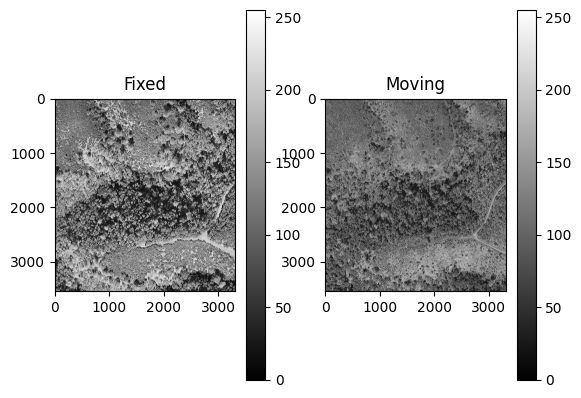

Updating most inliers to be 0
Final number of inliears is 1


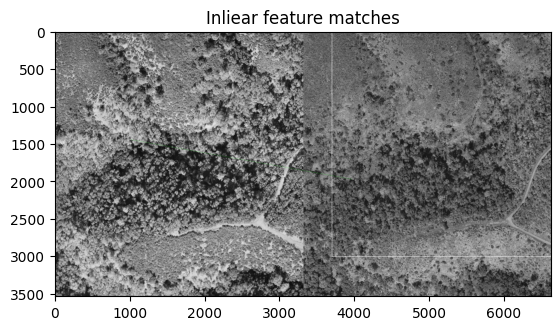

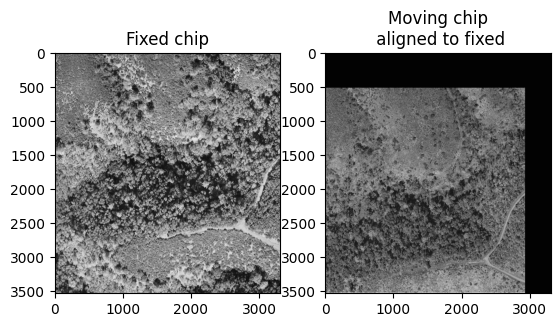

In [10]:
# Read the ROI and dissolve into a single geometry
ROI = gpd.read_file(ROI_FILE)
ROI = ROI.dissolve()

# Perform the registration
transforms = align_two_rasters(
    FIXED_ORTHO_FILENAME,
    MOVING_ORTHO_FILENAME,
    aligner_alg=cv2_feature_matcher,
    region_of_interest=ROI,
    target_GSD=TARGET_GSD,
    vis_chips=True,
)

Generate a shifted orthomosaic

In [11]:
update_transform(
    MOVING_ORTHO_FILENAME,
    SHIFTED_ORTHO_FILENAME,
    relative_transform=transforms["geospatial_mv2fx_transform"],
    update_existing=True,
)